In [1]:
import os, sklearn, pandas, numpy as np
from sklearn import svm
import skimage, skimage.io, skimage.filters
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
import keras
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Reshape, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model

Using TensorFlow backend.


In [3]:
# custom scripts
import config # params, constants
import data, models # functions that mutate outr data
from utils import utils, plot # custom functions, in local environment

 Dataset :: namedtuple(
    ['train' = ['img_name']
    , 'test' = ['img_name']
    , 'labels' = pandas.df('img_name','breed')
    , 'dict_index_to_label' = dict to convert label_index -> label_name
    , 'dict_label_to_index'= dict to convert label_name -> label_index
    


# Prepare dataset

In [4]:
import data # src/data.py
dataset = data.init_dataset()

In [5]:
# Read data
amt = 1000 # amount of train, test data
x_train, y_train, amt1 = data.extract_all(dataset, dataset.train[0:amt])
x_test, y_test, amt2 = data.extract_all(dataset, dataset.train[amt:amt + int(amt / 2)])
amt = amt1
print(amt1,amt2)
data.show_info(x_train)

extract all data: 1000
extract all data: 500
889 446
__ info: __
length:  889
type:  <class 'numpy.ndarray'>
shape:  (889, 250, 250, 3)


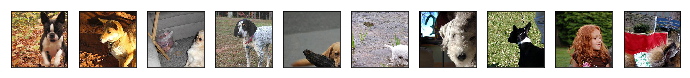

In [6]:
plot.multiple(x_train[:10])

### Prepare the labels

Encode the labels to one-hot vectors

In [7]:
# text-labels => int-labels
y_train = data.textlabels_to_numerical(dataset, y_train)
y_test = data.textlabels_to_numerical(dataset, y_test)
y_train[0:10]

[49, 44, 91, 18, 82, 25, 25, 94, 84, 112]

In [8]:
# int-labels => one-hot vectors
y_train = to_categorical(y_train)
# ? assuming y_test contains every possible class?
y_test = to_categorical(y_test)

print(y_train.shape, y_train[0].shape)
y_train[0]

(889, 120) (120,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

### Prepare images

In [9]:
# normalize data
# [0:255] => [0:1]
x_train = x_train / 255.
x_test = x_test / 255.

# Train a Sequential model (keras)

In [10]:
n_samples = x_train.shape[0] # = length of the list of images (matrices)
input_shape = x_train.shape[1:] # = shape of an individual image (matrix)
output_length = (y_train[0]).shape[0] # = length of an individual label
print('n samples:',n_samples)
print('shape:', input_shape)
print('output length:', output_length)

n samples: 889
shape: (250, 250, 3)
output length: 120


## Setup encoders

In [11]:
print(input_shape)
hidden_size = 2 # 2

input_ = Input(shape=input_shape)

x = Conv2D(4, (3, 3), activation='relu', padding='same', input_shape=input_shape)(input_)
# 1/2
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(hidden_size)(x)

(250, 250, 3)


In [12]:
encoder = Model(input_, x)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 4)       112       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 8)       520       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 16)        2064      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
__________

## Setup Decoder

In [13]:
# output_shape should be equal to input_shape
input_shape

(250, 250, 3)

In [14]:
encoded = Input(shape=(hidden_size,))

x = Dense(128)(encoded) # (None, 128)   
x = Reshape((4,4,8))(x) # (None, 4, 4, 8)  

x = UpSampling2D((8, 8))(x) # (None, 32, 32, 8)
x = Conv2D(4, (8, 8), activation='relu')(x) # (None, 25, 25, 4)
x = UpSampling2D((2, 2))(x) # (None, 100, 100, 4)
x = Conv2D(3, (1, 1), activation='relu')(x) # (None, 50, 50, 3) 

# go from 50x50 to input_shape[0:2] (=150x150)
a1 = round(input_shape[0] / 50)
a2 = round(input_shape[1] / 50)
param_a = (a1,a2) # (3,3)
print('param_a:',param_a)

x = UpSampling2D(param_a)(x) 

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoder = Model(encoded, decoded)

decoder.summary()

param_a: (5, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               384       
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 8)           0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 4)         2052      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 50, 50, 4)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 3)         15   

## Auto-encoder

In [15]:
auto = Model(input_, decoder(encoder(input_)))
auto.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 35466     
_________________________________________________________________
model_2 (Model)              (None, 250, 250, 3)       2535      
Total params: 38,001
Trainable params: 38,001
Non-trainable params: 0
_________________________________________________________________


### Loss function
Train with binary cross-entropy (each pixel is seen as a probability).

Training data (pixel values) must be normalized to [0:1]

In [16]:
auto.compile(optimizer='adam', loss='binary_crossentropy')

## Train model

In [17]:
# Compute a batch size
batch_size = 128
# n epochs = n iterations over all the training data
epochs = 16

In [18]:
x_train.shape

(889, 250, 250, 3)

In [19]:
# no validation is needed for the autoencoder, as the goal is to reconstruct the data as good as possible
auto.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

Epoch 1/16
889/889 [==============================] - 86s 96ms/step - loss: 0.6922
Epoch 2/16
889/889 [==============================] - 71s 80ms/step - loss: 0.6874
Epoch 3/16
889/889 [==============================] - 68s 77ms/step - loss: 0.6772
Epoch 4/16
889/889 [==============================] - 78s 88ms/step - loss: 0.6674
Epoch 5/16
889/889 [==============================] - 61s 68ms/step - loss: 0.6599
Epoch 6/16
889/889 [==============================] - 57s 64ms/step - loss: 0.6549
Epoch 7/16
889/889 [==============================] - 55s 62ms/step - loss: 0.6509
Epoch 8/16
889/889 [==============================] - 71s 80ms/step - loss: 0.6471
Epoch 9/16
889/889 [==============================] - 66s 74ms/step - loss: 0.6431
Epoch 10/16
889/889 [==============================] - 58s 65ms/step - loss: 0.6407
Epoch 11/16
889/889 [==============================] - 62s 69ms/step - loss: 0.6350
Epoch 12/16
889/889 [==============================] - 57s 64ms/step - loss: 0.6312
E

## Generate new images

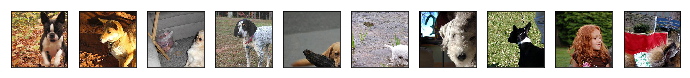

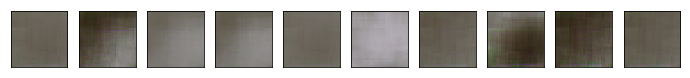

In [20]:
# old data
inputs1 = x_train[:10, :, :, :]
outputs1 = auto.predict(inputs1)

plot.multiple(inputs1[:10])
plot.multiple(outputs1[:10])

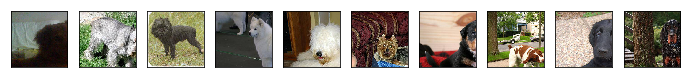

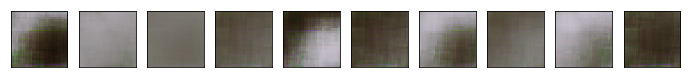

In [21]:
# new data
inputs = x_test[:10, :, :, :]
outputs = auto.predict(inputs)

plot.multiple(inputs[:10])
plot.multiple(outputs[:10])

In [22]:
# 
inputs2 = x_test[:10, :, :, :]
outputs2 = encoder.predict(inputs2)
print(outputs2)

[[-6.16691     0.70060563]
 [ 0.22250356 -2.005598  ]
 [-0.72743744  0.37564182]
 [-0.4582634   2.5514183 ]
 [ 4.839487    3.085757  ]
 [-0.88893414  4.278627  ]
 [-3.3703144  -1.9073323 ]
 [ 0.47103268  1.771913  ]
 [-1.3405576  -3.1397562 ]
 [-3.09018     4.1353893 ]]


10 [array([2.97226712, 2.41259715]), array([6.98667304, 0.9750397 ]), array([4.29178727, 1.53519017]), array([0.03281436, 0.02176016]), array([2.81173609, 6.49525801]), array([0.01585468, 0.11736347]), array([0.1348031 , 0.29962902]), array([1.21123718, 3.18128119]), array([0.05550006, 0.30299046]), array([0.04138993, 0.26625822])]


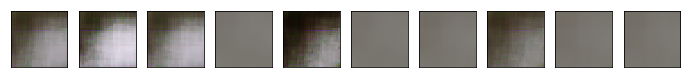

In [23]:
# samples = np.array([ [3,1.8] ])
scale = 10 # random value in range [-scale:scale]
samples = []
for x in range(10):
    sample = np.random.random([hidden_size]) * scale * ((np.random.random() - 0.5) * 2) ** 2
    samples.append(sample)

print(len(samples), samples)
samples = np.stack(samples)
results = decoder.predict(samples)
plot.multiple(results)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


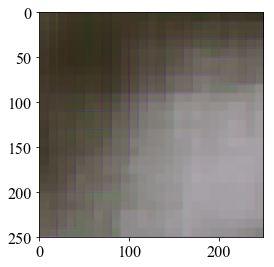

In [24]:
skimage.io.imshow(results[0])

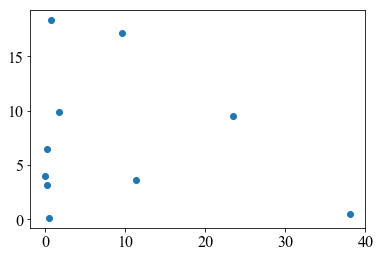

In [34]:
num = 10

inputs = x_test[:num, :, :, :]
latent = encoder.predict(inputs) ** 2

# plt.scatter(latent[:,0], latent[:,1], c=y_test[:num], alpha=0.1)
plt.scatter(latent[:,0],latent[:,1])